# ML Preprocessing Pipeline
- to run `pyspark --packages org.diana-hep:spark-root_2.11:0.1.14`

In [1]:
df = sqlContext.read.format("org.dianahep.sparkroot.experimental").load("file:/Users/vk/data/ML_MP_JR/ttbar_lepFilter_13TeV")

## Print the total schema
- All the top columns are present

In [2]:
df.printSchema()

root
 |-- Event: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- fUniqueID: integer (nullable = true)
 |    |    |-- fBits: integer (nullable = true)
 |    |    |-- Number: long (nullable = true)
 |    |    |-- ReadTime: float (nullable = true)
 |    |    |-- ProcTime: float (nullable = true)
 |    |    |-- ProcessID: integer (nullable = true)
 |    |    |-- MPI: integer (nullable = true)
 |    |    |-- Weight: float (nullable = true)
 |    |    |-- Scale: float (nullable = true)
 |    |    |-- AlphaQED: float (nullable = true)
 |    |    |-- AlphaQCD: float (nullable = true)
 |    |    |-- ID1: integer (nullable = true)
 |    |    |-- ID2: integer (nullable = true)
 |    |    |-- X1: float (nullable = true)
 |    |    |-- X2: float (nullable = true)
 |    |    |-- ScalePDF: float (nullable = true)
 |    |    |-- PDF1: float (nullable = true)
 |    |    |-- PDF2: float (nullable = true)
 |-- Event_size: integer (nullable = true)
 |-- Particle: arr

## Step 1: Select the top colums to be used and do a count of rows

In [3]:
requiredColumns = ["EFlowTrack", "MuonTight_size", "Electron_size", "EFlowNeutralHadron", "EFlowPhoton", "Electron", "MuonTight", "MissingET", "Jet"]
events = df.select(requiredColumns).toDF(*requiredColumns)
events.count()

50000

## Step 2: Produce Some simple plots
- import histogrammar

In [4]:
import histogrammar as hg
bins = {
    "PT" : hg.Bin(100, 0, 20, lambda track: track.PT),
    "Eta" : hg.Bin(100, -5, 5, lambda track: track.Eta),
    "Phi" : hg.Bin(100, -3.14, 3.14, lambda track: track.Phi),
    "X" : hg.Bin(10000, -1, 1, lambda track: track.X),
    "Y" : hg.Bin(10000, -1, 1, lambda track: track.Y)
}
emptyLabel = hg.Label(**bins)

In [5]:
tracks = events.select("EFlowTrack").rdd.flatMap(lambda row: row.EFlowTrack)
tracks.toDF().printSchema()

SyntaxError: invalid syntax (<ipython-input-5-ee1a0df49b1c>, line 1)

In [ ]:
filledLabel = tracks.aggregate(emptyLabel, hg.increment, hg.combine)

In [9]:
%matplotlib inline

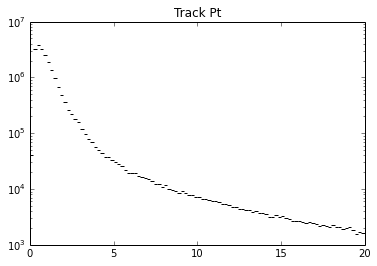

In [31]:
axes = filledLabel.get("PT").plot.matplotlib(name="Track Pt").set_yscale("log")

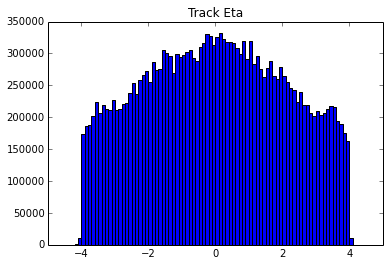

In [22]:
filledLabel.get("Eta").plot.matplotlib(name="Track Eta")

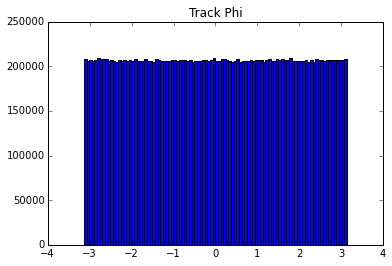

In [21]:
filledLabel.get("Phi").plot.matplotlib(name="Track Phi")

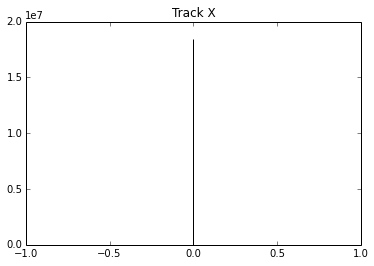

In [23]:
filledLabel.get("X").plot.matplotlib(name="Track X")

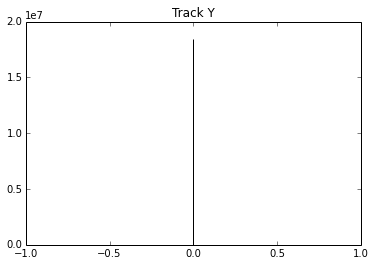

In [24]:
filledLabel.get("Y").plot.matplotlib(name="Track Y")

## Step 3: Prepare the Pipeline as is (taken from conversion2H5.py)
- set of aux functions
- redefine TLorentzVector - have to debug further - might've made some trigonometry mistakes
- baseline pipeline mimicking the Event Loop

In [28]:
import numpy as np
import math
import time
from pyspark.sql import Row

In [29]:
def PFIso(p, DR, PtMap, subtractPt):
    if p.Pt() <= 0.: return 0.
    DeltaEta = PtMap[:,0] - p.Eta()
    DeltaPhi = PtMap[:,1] - p.Phi()
    twopi = 2.*3.1415
    DeltaPhi = DeltaPhi - twopi*(DeltaPhi >  twopi) + twopi*(DeltaPhi < -1.*twopi)
    isInCone = DeltaPhi*DeltaPhi + DeltaEta*DeltaEta < DR*DR
    Iso = PtMap[isInCone, 2].sum()/p.Pt()
    if subtractPt: Iso = Iso -1
#    print(type(Iso))
    return float(Iso)

# get the selected tracks
def ChPtMapp(DR, event):
    pTmap = []
    for h in event.EFlowTrack:
        if h.PT<= 0.5: continue
        pTmap.append([h.Eta, h.Phi, h.PT])
        #nParticles += 1
    #pTmap = np.reshape(pTmap, (nParticles, 3))
    return np.asarray(pTmap)

# get the selected neutrals
def NeuPtMapp(DR, event):
    pTmap = []
    #nParticles = 0
    for h in event.EFlowNeutralHadron:
        if h.ET<= 1.0: continue
        pTmap.append([h.Eta, h.Phi, h.ET])
        #nParticles += 1
    #pTmap = np.reshape(pTmap, (nParticles, 3))
    return np.asarray(pTmap)

# get the selected photons
def PhotonPtMapp(DR, event):
    pTmap = []
    #nParticles = 0
    for h in event.EFlowPhoton:
        if h.ET<= 1.0: continue
        pTmap.append([h.Eta, h.Phi, h.ET])
        #nParticles += 1
    #pTmap = np.reshape(pTmap, (nParticles, 3))
    return np.asarray(pTmap)

class LorentzVector(object):
    def __init__(self, *args):
        if len(args)>0:
            self.x = args[0]
            self.y = args[1]
            self.z = args[2]
            self.t = args[3]
    
    def SetPtEtaPhiM(self, pt, eta, phi, mass):
        pt = abs(pt)
        print pt
        self.SetXYZM(pt*math.cos(phi), pt*math.sin(phi), pt*math.sinh(eta), mass)
        
    def SetXYZM(self, x, y, z, m):
        print x,y,z,m
        self.x = x;
        self.y = y
        self.z = z
        if (m>=0):
            self.t = math.sqrt(x*x + y*y + z*z + m*m)
        else:
            self.t = math.sqrt(max(x*x + y*y + z*z - m*m, 0))
            
    def E(self):
        return self.t
    
    def Px(self): 
        return self.x
    
    def Py(self):
        return self.y
    
    def Pz(self):
        return self.z
    
    def Pt(self):
        return math.sqrt(self.x*self.x + self.y*self.y)
    
    def Eta(self):
        cosTheta = self.CosTheta()
        if cosTheta*cosTheta<1:
            return -0.5*math.log((1.0 - cosTheta)/(1.0 + cosTheta))
        if self.z == 0: return 0
    
    def mag(self):
        return math.sqrt(self.x*self.x + self.y*self.y + self.z*self.z)
    
    def CosTheta(self):
        return 1.0 if self.mag()==0.0 else self.z/self.mag()
    
    def Phi(self):
        return math.tan(self.y/self.x)
    
    def Phi_mpi_pi(self, x):
        while x >= 3.1415: 
            x -= 2*3.1415
        while x < -3.1415:
            x += 2*3.1415
        return x
    
    def DeltaR(self, other):
        deta = self.Eta() - other.Eta()
        dphi = self.Phi_mpi_pi(self.Phi() - other.Phi())
        return math.sqrt(deta*deta + dphi*dphi)
    
def mysign_func(v):
    if v<0: return -1
    elif v==0: return 0
    else: return 1

In [30]:
def selection(event, TrkPtMap, NeuPtMap, PhotonPtMap):
    # one electron or muon with pT> 15 GeV
    if event.Electron_size == 0 and event.MuonTight_size == 0: return False, False, False
    foundMuon = None #[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0, 0, 0, 1, 1]
    foundEle =  None #[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0, 0, 1, 0, 1]
    
    #
    # Has to replace the TLorentzVector functionality
    #
    l = LorentzVector()
    for ele in event.Electron:
        if ele.PT <= 25.: continue
        #
        # Has to replace the TLorentzVector functionality
        #
        l.SetPtEtaPhiM(ele.PT, ele.Eta, ele.Phi, 0.)
        
        pfisoCh = PFIso(l, 0.3, TrkPtMap, True)
        pfisoNeu = PFIso(l, 0.3, NeuPtMap, False)
        pfisoGamma = PFIso(l, 0.3, PhotonPtMap, False)
        if foundEle == None and (pfisoCh+pfisoNeu+pfisoGamma)<0.2:
            #foundEle.SetPtEtaPhiM(ele.PT, ele.Eta, ele.Phi, 0.)
            foundEle = [l.E(), l.Px(), l.Py(), l.Pz(), l.Pt(), l.Eta(), l.Phi(), 0., 0., 0., pfisoCh, pfisoGamma, pfisoNeu, 0, 0, 0, 1, 0, ele.Charge]
    for muon in event.MuonTight:
        if muon.PT <= 25.: continue
        #
        # Has to replace the TLorentzVector functionality
        #
        l.SetPtEtaPhiM(muon.PT, muon.Eta, muon.Phi, 0.)
        
        pfisoCh = PFIso(l, 0.3, TrkPtMap, True)
        pfisoNeu = PFIso(l, 0.3, NeuPtMap, False)
        pfisoGamma = PFIso(l, 0.3, PhotonPtMap, False)
        if foundMuon == None and (pfisoCh+pfisoNeu+pfisoGamma)<0.2:
            foundMuon = [l.E(), l.Px(), l.Py(), l.Pz(), l.Pt(), l.Eta(), l.Phi(), 0., 0., 0., pfisoCh, pfisoGamma, pfisoNeu, 0, 0, 0, 0, 1, muon.Charge]
    if foundEle != None and foundMuon != None:
        if foundEle[5] > foundMuon[5]:
            return True, foundEle, foundMuon
        else:
            return True, foundMuon, foundEle
    if foundEle != None: return True, foundEle, foundMuon
    if foundMuon != None: True, foundMuon, foundEle
    return False, None, None

In [31]:
def convert(event):
    q = LorentzVector()
    particles = []
    TrkPtMap = ChPtMapp(0.3, event)
    NeuPtMap = NeuPtMapp(0.3, event)
    PhotonPtMap = PhotonPtMapp(0.3, event)
    if TrkPtMap.shape[0] == 0: return Row()
    if NeuPtMap.shape[0] == 0: return Row()
    if PhotonPtMap.shape[0] == 0: return Row()
    
    #
    # Get leptons
    #
    selected, lep, otherlep = selection(event, TrkPtMap, NeuPtMap, PhotonPtMap)
    if not selected: return Row()
    particles.append(lep)
    lepMomentum = LorentzVector(lep[1], lep[2], lep[3], lep[0])
    nTrk = 0
    
    #
    # Select Tracks
    #
    for h in event.EFlowTrack:
        if nTrk>=450: continue
        if h.PT<=0.5: continue
        q.SetPtEtaPhiM(h.PT, h.Eta, h.Phi, 0.)
        if lepMomentum.DeltaR(q) > 0.0001:
            pfisoCh = PFIso(q, 0.3, TrkPtMap, True)
            pfisoNeu = PFIso(q, 0.3, NeuPtMap, False)
            pfisoGamma = PFIso(q, 0.3, PhotonPtMap, False)
            particles.append([q.E(), q.Px(), q.Py(), q.Pz(), h.PT, h.Eta, h.Phi, h.X, h.Y, h.Z, pfisoCh, pfisoGamma, pfisoNeu, 1, 0, 0, 0, 0, mysign_func(h.PID)])
            nTrk += 1
    nPhoton = 0
    
    #
    # Select Photons
    #
    for h in event.EFlowPhoton:
        if nPhoton >= 150: continue
        if h.ET <= 1.: continue
        q.SetPtEtaPhiM(h.ET, h.Eta, h.Phi, 0.)
        pfisoCh = PFIso(q, 0.3, TrkPtMap, True)
        pfisoNeu = PFIso(q, 0.3, NeuPtMap, False)
        pfisoGamma = PFIso(q, 0.3, PhotonPtMap, False)
        particles.append([q.E(), q.Px(), q.Py(), q.Pz(), h.ET, h.Eta, h.Phi, 0., 0., 0., pfisoCh, pfisoGamma, pfisoNeu, 0, 0, 1, 0, 0, 0])
        nPhoton += 1
    nNeu = 0
    
    #
    # Select Neutrals
    #
    for h in event.EFlowNeutralHadron:
        if nNeu >= 200: continue
        if h.ET <= 1.: continue
        q.SetPtEtaPhiM(h.ET, h.Eta, h.Phi, 0.)
        pfisoCh = PFIso(q, 0.3, TrkPtMap, True)
        pfisoNeu = PFIso(q, 0.3, NeuPtMap, False)
        pfisoGamma = PFIso(q, 0.3, PhotonPtMap, False)
        particles.append([q.E(), q.Px(), q.Py(), q.Pz(), h.ET, h.Eta, h.Phi, 0., 0., 0., pfisoCh, pfisoGamma, pfisoNeu, 0, 1, 0, 0, 0, 0])
        nNeu += 1
    for iTrk in range(nTrk, 450):
        particles.append([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
    for iPhoton in range(nPhoton, 150):
        particles.append([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
    for iNeu in range(nNeu, 200):
        particles.append([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
    return Row(features=particles)

In [33]:
# map the event to either
# 1) empty row
# 2) row of features
#    .limit(100)\
before = time.time()
featured_df = events\
    .limit(100)\
    .rdd\
    .map(convert)\
    .filter(lambda row: len(row) > 0)\
    .toDF()
after = time.time()
print("Total Processing Time: %d seconds" % int(after - before))

Total Processing Time: 14 seconds


In [9]:
featured_df.printSchema()

root
 |-- features: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)



In [10]:
featured_df.show()

+--------------------+
|            features|
+--------------------+
|[WrappedArray(44....|
|[WrappedArray(67....|
|[WrappedArray(189...|
|[WrappedArray(36....|
|[WrappedArray(31....|
|[WrappedArray(60....|
|[WrappedArray(386...|
|[WrappedArray(76....|
|[WrappedArray(44....|
|[WrappedArray(65....|
|[WrappedArray(51....|
|[WrappedArray(121...|
|[WrappedArray(43....|
|[WrappedArray(292...|
|[WrappedArray(705...|
|[WrappedArray(70....|
|[WrappedArray(319...|
|[WrappedArray(53....|
|[WrappedArray(48....|
|[WrappedArray(80....|
+--------------------+
only showing top 20 rows



In [11]:
featured_df.write.parquet("file:/Users/vk/data/ML_MP_JR/ttbar_lepFilter_13TeV/ttbar_features.parquet", mode="overwrite")

## Step 4: Introduce UDFs
- Import UDFs
- Select Electron with UDF
- Select Muon with UDF
- Select tracks / neutrals / photons 
- generate the features

In [17]:
from pyspark.sql.functions import size,udf,col
from pyspark.sql.types import *
import numpy as np
import math
import time

In [18]:
class LorentzVector(object):
    def __init__(self, *args):
        if len(args)>0:
            self.x = args[0]
            self.y = args[1]
            self.z = args[2]
            self.t = args[3]
    
    def SetPtEtaPhiM(self, pt, eta, phi, mass):
        pt = abs(pt)
        self.SetXYZM(pt*math.cos(phi), pt*math.sin(phi), pt*math.sinh(eta), mass)
        
    def SetXYZM(self, x, y, z, m):
        self.x = x;
        self.y = y
        self.z = z
        if (m>=0):
            self.t = math.sqrt(x*x + y*y + z*z + m*m)
        else:
            self.t = math.sqrt(max(x*x + y*y + z*z - m*m, 0))
            
    def E(self):
        return self.t
    
    def Px(self): 
        return self.x
    
    def Py(self):
        return self.y
    
    def Pz(self):
        return self.z
    
    def Pt(self):
        return math.sqrt(self.x*self.x + self.y*self.y)
    
    def Eta(self):
        cosTheta = self.CosTheta()
        if cosTheta*cosTheta<1:
            return -0.5*math.log((1.0 - cosTheta)/(1.0 + cosTheta))
        if self.z == 0: return 0
    
    def mag(self):
        return math.sqrt(self.x*self.x + self.y*self.y + self.z*self.z)
    
    def CosTheta(self):
        return 1.0 if self.mag()==0.0 else self.z/self.mag()
    
    def Phi(self):
        return math.tan(self.y/self.x)
    
    def Phi_mpi_pi(self, x):
        while x >= 3.1415: 
            x -= 2*3.1415
        while x < -3.1415:
            x += 2*3.1415
        return x
    
    def DeltaR(self, other):
        deta = self.Eta() - other.Eta()
        dphi = self.Phi_mpi_pi(self.Phi() - other.Phi())
        return math.sqrt(deta*deta + dphi*dphi)
    
def mysign_func(v):
    if v<0: return -1
    elif v==0: return 0
    else: return 1

In [23]:
def PFIso(p, DR, PtMap, subtractPt):
    if p.Pt() <= 0.: return 0.
    nPtMap = np.asarray(PtMap)
    DeltaEta = nPtMap[:,0] - p.Eta()
    DeltaPhi = nPtMap[:,1] - p.Phi()
    twopi = 2.*3.1415
    DeltaPhi = DeltaPhi - twopi*(DeltaPhi >  twopi) + twopi*(DeltaPhi < -1.*twopi)
    isInCone = DeltaPhi*DeltaPhi + DeltaEta*DeltaEta < DR*DR
    Iso = nPtMap[isInCone, 2].sum()/p.Pt()
    if subtractPt: Iso = Iso -1
#    print(type(Iso))
    return float(Iso)

@udf(returnType=ArrayType(ArrayType(DoubleType())))
def addChargedTracks(tracks):
    filtered = filter(lambda x: x.PT>0.5, tracks)
    return [[t.Eta, t.Phi, t.PT] for t in filtered]

@udf(returnType=ArrayType(ArrayType(DoubleType())))
def addNeutrals(neutrals):
    filtered = filter(lambda x: x.ET>1.0, neutrals)
    return [[n.Eta, n.Phi, n.ET] for n in filtered]

@udf(returnType=ArrayType(ArrayType(DoubleType())))
def addPhotons(photons):
    filtered = filter(lambda x: x.ET>1.0, photons)
    return [[n.Eta, n.Phi, n.ET] for n in filtered]    

@udf(returnType=ArrayType(DoubleType()))
def addElectron(esize, electrons, chargedTracks, neutrals, photons):
    if esize == 0:
        return []
    foundEle = None
    l = LorentzVector()
    for ele in electrons:
        if ele.PT <= 25.: 
            continue
        l.SetPtEtaPhiM(ele.PT, ele.Eta, ele.Phi, 0.)
        pfisoCh = PFIso(l, 0.3, chargedTracks, True)
        pfisoNeu = PFIso(l, 0.3, neutrals, False)
        pfisoGamma = PFIso(l, 0.3, photons, False)
        if foundEle == None and (pfisoCh+pfisoNeu+pfisoGamma)<0.2:
            foundEle = [l.E(), l.Px(), l.Py(), l.Pz(), l.Pt(), l.Eta(), l.Phi(), 0., 0., 0., pfisoCh, pfisoGamma, pfisoNeu, 0, 0, 0, 1, 0, ele.Charge]
    return [] if foundEle==None else foundEle
    
@udf(returnType=ArrayType(DoubleType()))
def addMuon(msize, muons, chargedTracks, neutrals, photons):
    if msize==0: 
        return []
    foundMuon = None
    l = LorentzVector()
    for muon in muons:
        if muon.PT <= 25.: 
            continue
        l.SetPtEtaPhiM(muon.PT, muon.Eta, muon.Phi, 0.)
        pfisoCh = PFIso(l, 0.3, chargedTracks, True)
        pfisoNeu = PFIso(l, 0.3, neutrals, False)
        pfisoGamma = PFIso(l, 0.3, photons, False)
        if foundMuon == None and (pfisoCh+pfisoNeu+pfisoGamma)<0.2:
            foundMuon = [l.E(), l.Px(), l.Py(), l.Pz(), l.Pt(), l.Eta(), l.Phi(), 0., 0., 0., pfisoCh, pfisoGamma, pfisoNeu, 0, 0, 0, 0, 1, muon.Charge]
    return [] if foundMuon==None else foundMuon

@udf(returnType=ArrayType(DoubleType()))
def selectLepton(electron, muon):
    """Assume that at least 1 is not empty list"""
    if electron == []: return muon
    if muon == []: return electron
    return electron if electron[5]>muon[5] else muon

def selectLepton_noudf(electron, muon):
    """Assume that at least 1 is not empty"""
    if electron == []: return muon
    if muon == []: return electron
    return electron if electron[5]>muon[5] else muon

In [24]:
@udf(returnType=ArrayType(DoubleType()))
def lepton_features(electron, muon):
    """Assume that at least 1 is not empty"""
    if electron == []: return muon
    if muon == []: return electron
    return electron if electron[5]>muon[5] else muon

@udf(returnType=ArrayType(ArrayType(DoubleType())))
def track_features(alltracks, lepton, selectedTracks, selectedPhotons, selectedNeutrals):
    features = []
    q = LorentzVector()
    
    # add charged Tracks
    lepMomentum = LorentzVector(lepton[1], lepton[2], lepton[3], lepton[0])
    nTrk = 0
    for h in alltracks:
        if nTrk>=450: continue
        if h.PT<=0.5: continue
        q.SetPtEtaPhiM(h.PT, h.Eta, h.Phi, 0.)
        if lepMomentum.DeltaR(q) > 0.0001:
            pfisoCh = PFIso(q, 0.3, selectedTracks, True)
            pfisoNeu = PFIso(q, 0.3, selectedNeutrals, False)
            pfisoGamma = PFIso(q, 0.3, selectedPhotons, False)
            features.append([q.E(), q.Px(), q.Py(), q.Pz(), h.PT, h.Eta, h.Phi, h.X, h.Y, h.Z, pfisoCh, pfisoGamma, pfisoNeu, 1, 0, 0, 0, 0, mysign_func(h.PID)])
            nTrk += 1
    return features

@udf(returnType=ArrayType(ArrayType(DoubleType())))
def neutral_features(allneutrals, lepton, selectedTracks, selectedPhotons, selectedNeutrals):
    features = []
    q = LorentzVector()
    
    # add charged Tracks
    lepMomentum = LorentzVector(lepton[1], lepton[2], lepton[3], lepton[0])
    n = 0
    
    # loop
    for h in allneutrals:
        if n >= 200: 
            continue
        if h.ET <= 1.: 
            continue
        q.SetPtEtaPhiM(h.ET, h.Eta, h.Phi, 0.)
        if lepMomentum.DeltaR(q) > 0.0001:
            pfisoCh = PFIso(q, 0.3, selectedTracks, True)
            pfisoNeu = PFIso(q, 0.3, selectedNeutrals, False)
            pfisoGamma = PFIso(q, 0.3, selectedPhotons, False)
            features.append([q.E(), q.Px(), q.Py(), q.Pz(), h.ET, h.Eta, h.Phi, 0, 0, 0, pfisoCh, pfisoGamma, pfisoNeu, 0, 1, 0, 0, 0, 0])
            n += 1
    return features

@udf(returnType=ArrayType(ArrayType(DoubleType())))
def photon_features(allphotons, lepton, selectedTracks, selectedPhotons, selectedNeutrals):
    features = []
    q = LorentzVector()
    
    # lepton 4 vector
    lepMomentum = LorentzVector(lepton[1], lepton[2], lepton[3], lepton[0])
    n = 0
    
    # loop
    for h in allphotons:
        if n >= 150: continue
        if h.ET <= 1.: continue
        q.SetPtEtaPhiM(h.ET, h.Eta, h.Phi, 0.)
        if lepMomentum.DeltaR(q) > 0.0001:
            pfisoCh = PFIso(q, 0.3, selectedTracks, True)
            pfisoNeu = PFIso(q, 0.3, selectedNeutrals, False)
            pfisoGamma = PFIso(q, 0.3, selectedPhotons, False)
            features.append([q.E(), q.Px(), q.Py(), q.Pz(), h.ET, h.Eta, h.Phi, 0, 0, 0, pfisoCh, pfisoGamma, pfisoNeu, 0, 0, 1, 0, 0, 0])
            n += 1
    return features

In [26]:
# map the event to either
# 1) empty row
# 2) row of features
#    .limit(100)\
#esize, electrons, chargedTracks, neutrals, photons
before_withUDF = time.time()
#featured_df_withUDF = 
#    .filter((col("Electron_size") > 0) | (col("MuonTight_size") > 0))\
events\
    .limit(100)\
    .withColumn("chargedTracks", addChargedTracks("EFlowTrack"))\
    .filter(size("chargedTracks") > 0)\
    .withColumn("neutrals", addNeutrals("EFlowNeutralHadron"))\
    .filter(size("neutrals") > 0)\
    .withColumn("photons", addPhotons("EFlowPhoton"))\
    .filter(size("photons") > 0)\
    .withColumn("electron", addElectron("Electron_size", "Electron", "chargedTracks", "neutrals", "photons"))\
    .withColumn("muon", addMuon("MuonTight_size", "MuonTight", "chargedTracks", "neutrals", "photons"))\
    .filter((size("electron")>0) | (size("muon")>0))\
    .withColumn("lepton_features", lepton_features("electron", "muon"))\
    .withColumn("track_features", track_features("EFlowTrack", "lepton_features", 
                                                 "chargedTracks", "neutrals", "photons"))\
    .withColumn("neutral_features", neutral_features("EFlowNeutralHadron", "lepton_features", 
                                                 "chargedTracks", "neutrals", "photons"))\
    .withColumn("photon_features", photon_features("EFlowPhoton", "lepton_features", 
                                                 "chargedTracks", "neutrals", "photons"))\
    .select("lepton_features", "track_features", "neutral_features", "photon_features")\
    .show()
    
after_withUDF = time.time()
print("Total Processing Time: %d seconds" % int(after_withUDF - before_withUDF))

+--------------------+--------------------+--------------------+--------------------+
|     lepton_features|      track_features|    neutral_features|     photon_features|
+--------------------+--------------------+--------------------+--------------------+
|[44.1709594231936...|[WrappedArray(17....|[WrappedArray(59....|[WrappedArray(79....|
|[67.5085260109316...|[WrappedArray(32....|[WrappedArray(90....|[WrappedArray(108...|
|[189.266695547177...|[WrappedArray(19....|[WrappedArray(102...|[WrappedArray(113...|
|[36.1645340483160...|[WrappedArray(39....|[WrappedArray(88....|[WrappedArray(78....|
|[31.7983312547415...|[WrappedArray(14....|[WrappedArray(88....|[WrappedArray(85....|
|[60.8118823139215...|[WrappedArray(15....|[WrappedArray(128...|[WrappedArray(58....|
|[386.114238317159...|[WrappedArray(17....|[WrappedArray(133...|[WrappedArray(89....|
|[76.3736410571715...|[WrappedArray(1.0...|[WrappedArray(104...|[WrappedArray(94....|
|[44.5030086930294...|[WrappedArray(22....|[WrappedArr